# Quantum Software (with PyZX!)

_Aleks Kissinger | 2023_


This problem sheet is designed to go with the [Quantum Software](https://www.cs.ox.ac.uk/teaching/courses/2022-2023/qsoft/) course taught in Oxford, but if you came across it another way, you are more than welcome to give it a go! The primary goals of this and the next sheet are to:
1. construct quantum circuits and ZX-diagrams programmatically
2. evaluate/simulate them numerically
3. do basic diagrammatic reasoning with software
4. apply 1-3 to a practical example of a quantum computation

Along the way, we'll achieve a secondary goal:
5. learn a bit about [NISQ](https://arxiv.org/abs/1801.00862) quantum hardware available today, and how to make use of it via cloud quantum computing

If you are following the Quantum Software course at Oxford, you should have a good idea of what _ZX-diagrams_ and the _ZX-calculus_ are. If not, have a look at [ZX-calculus for the working quantum computer scientist](https://arxiv.org/abs/2012.13966). A short tutorial and pretty comprehensive list of references can also be found at [zxcalculus.com](http://www.zxcalculus.com). Everything you need to know about the PyZX library should be introduced as we go, but if you need more, the full code documentation is at [pyzx.readthedocs.io](https://pyzx.readthedocs.io/en/latest/).

We will only be scratching the surface on quantum hardware and software in these practicals. To learn more about the big picture, a great place to get started is [fullstackquantumcomputation.tech](https://fullstackquantumcomputation.tech/).

_These problem sheets, like PyZX itself are released under the [Apache 2](https://github.com/Quantomatic/pyzx/blob/master/LICENSE) open-source license. Feel free to use, copy, and modify them at will, e.g. to use your own course._

# Part 1

Alright, lets get stuck in! This is a [Jupyter](https://jupyter.org/) notebook, which is a place for running bits of python code and seeing (and saving) pretty output. Some of the code is written for you, and some of it you will write yourself. As you go through, you will find code blocks marked `In [ ]:`. Click inside of these blocks and press `SHIFT+ENTER` to run the code. Some code defines variables used by other code, so make sure you do this in the right order.

The first thing we'll do is install the PyZX library if we don't have it already. Jupyter notebooks have a "magic" command for installing libraries called `%pip`. So, run this first to install PyZX. You should only need to do it once. (You can delete the command later if you like.)

Note we are installing the git version of pyzx here. To install the latest release, use simply `pip install pyzx`.

If it claims you need to "restart the kernel" click the refresh-looking button in the Jupyter toolbar, or go to `Kernel > Restart`.

In [ ]:
%pip install "pyzx @ git+https://github.com/Quantomatic/pyzx.git"

Next, we'll import some stuff from the Python standard library. In particular, we'll use the `Fraction` type for expressing phases later.

In [ ]:
import sys, os, math
from fractions import Fraction

And now we import `pyzx` itself. To save us some extra typing, we'll abbreviate the name to `zx`, import all the basic rules, and make some other useful abbreviations.

In [ ]:
import pyzx as zx
from pyzx import print_matrix
from pyzx.basicrules import *

Z = zx.VertexType.Z
X = zx.VertexType.X
B = zx.VertexType.BOUNDARY
SE = zx.EdgeType.SIMPLE
HE = zx.EdgeType.HADAMARD

ZX-diagrams are string diagrams (aka tensor networks) made up of 2 special generators: _Z-spiders_ and _X-spiders_.

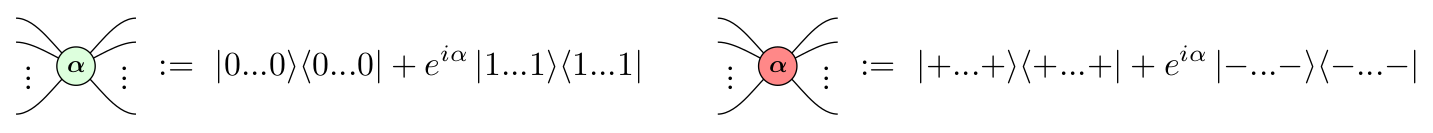

A useful thing about these generators is they are invariant under changing the order of inputs/outputs, or even changing an input to an output. Hence, in PyZX, we represent ZX-diagrams as indirected graphs.

In the previous code block, you saw there were 3 kinds of `VertexType`s we use in graphs: `Z`, `X`, and `B(OUNDARY)`. The first two correspond to Z and X (i.e. green and red) spiders, whereas the third one is a dummy type we use for representing inputs and outputs of the diagram, i.e. wires which are not connected to a spider at one end.

To get started, lets make a Z-copy spider, i.e. a Z-spider with 1 input, 2 outputs, and no phase.

In [ ]:
# create a new, empty graph
zcopy = zx.Graph()

# add_vertex adds a vertex of a given type and returns an id that we
# can refer to later
in1  = zcopy.add_vertex(B, qubit=1, row=0)
z1   = zcopy.add_vertex(Z, qubit=1, row=1)
out1 = zcopy.add_vertex(B, qubit=0, row=2)
out2 = zcopy.add_vertex(B, qubit=2, row=2)

# add_edge takes a pair of vertex id's and creates an edge. Note the
# double-parentheses!
zcopy.add_edge((in1,z1))
zcopy.add_edge((z1,out1))
zcopy.add_edge((z1,out2))

# tell pyzx which boundary vertices should count as 'inputs' and which
# as 'outputs', and in what order. This only matters for sequential
# composition.
zcopy.set_inputs((in1,))
zcopy.set_outputs((out1,out2))

Most of the time, we won't be building graphs by hand, but it's useful to get an idea of how the data structure works. One thing to note is `add_vertex` takes two parameters `row` and `qubit` which tell PyZX where that vertex should be drawn. These names make sense in the context of a ZX-diagram that came from a quantum circuit, as we'll see later. However, for generic ZX-diagrams, it suffices to think of `row` and `qubit` as X and Y coordinates for positioning vertices on the screen.

Speaking of drawing, we do that with `zx.draw`:

In [ ]:
zx.draw(zcopy)

Note you can move vertices around by clicking and dragging. This comes in handy when the graphs get more complicated.

Now, lets make graphs that correspond to a single wire (i.e. the identity process) and the swap. We use a convenience method called `auto_detect_io`, which tries to guess which boundaries should be inputs and outputs, and orders them from top to bottom.

In [ ]:
wire = zx.Graph()
in1  = wire.add_vertex(B, qubit=0, row=0)
out1 = wire.add_vertex(B, qubit=0, row=1)
wire.add_edge((in1,out1))
wire.auto_detect_io()

print("wire :=")
zx.draw(wire)

swap = zx.Graph()
in1  = swap.add_vertex(B, qubit=0, row=0)
in2  = swap.add_vertex(B, qubit=1, row=0)
out1 = swap.add_vertex(B, qubit=0, row=1)
out2 = swap.add_vertex(B, qubit=1, row=1)
swap.add_edge((in1,out2))
swap.add_edge((in2,out1))
swap.auto_detect_io()

print("swap :=")
zx.draw(swap)

Rather than starting from scratch, we can make an X-merge by taking the adjoint of Z-copy, then changing the Z vertex to an X vertex with `set_type`. Note: we needed to know that the id of the Z vertex is equal to 1.

In [ ]:
xmerge = zcopy.adjoint()
z1 = 1
xmerge.set_type(z1, X)
zx.draw(xmerge)

We can set the phase of a spider with `set_phase`, or use the optional `phase=` paremeter to `add_vertex`. It is given as a rational multiple of pi, so we use Python's built-in `Fraction` type for this.

In [ ]:
xmerge_pi4 = xmerge.copy()
xmerge_pi4.set_phase(z1, Fraction(1,4))
zx.draw(xmerge_pi4)

<hr style="border-bottom:3px solid black" />

## Question 1.1

Make an X-merge operation that takes 3 inputs instead of two and has a phase of pi/3 and draw it.


<hr style="border-top:3px solid black" />

Unless you have a really crazy keyboard, you probably don't have keys for ⊗ and ∘. But, you probably have `@` and `*`, so these will have to do.

In [ ]:
g = zcopy @ xmerge # parallel composition
zx.draw(g)

In [ ]:
g = zcopy * xmerge # sequential composition
zx.draw(g)

Let's see what happens if we compose the other way around:

In [ ]:
g = xmerge * zcopy
zx.draw(g)

Where did the edges go? To keep things simple, the `Graph` type does not allow more than one edge between a pair of vertices. This means if we _do_ produce a situation where there would have been more than one edge, PyZX fixes this up automatically, using the spider fusion rule (if the colours are the same) or complementarity rule (if the colours are different):

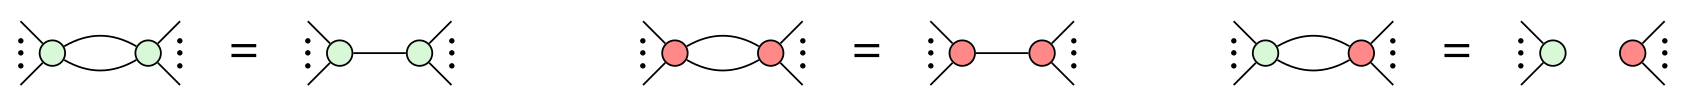

Note the `add_edge` method is too dumb to do this: calling it multiple times for the same vertices has the same effect as calling it once. On the other hand, `add_edge_smart` will automatically "Do the Right Thing" when there is already an edge there.

<hr style="border-bottom:3px solid black" />

## Question 1.2

Produce the following diagrams using parallel and sequential compositions of the generators we have already:

<div>
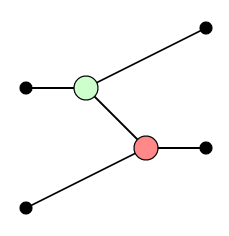
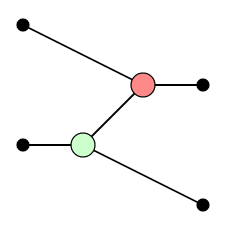
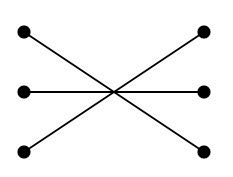
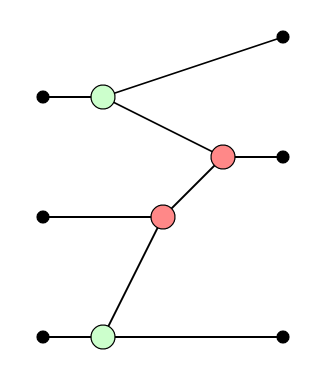
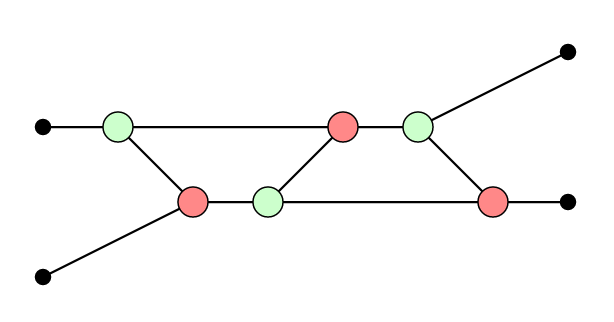
</div>

_Note: if you compose things in a different order, your diagram might look a little bit different. Remember only connectivity matters!_

<hr style="border-bottom:3px solid black" />

Particularly when we are interested in quantum circuits, it is often more convenient to input them using a simple textual format called [OpenQASM](https://en.wikipedia.org/wiki/OpenQASM). This stands for Open Quantum ASseMbly language. We can produce a circuit by passing a bit of QASM code to the `zx.qasm` function.

In [ ]:
circ = zx.qasm("""
qreg q[3];

cx q[0], q[1];
s q[1];
h q[1];
cz q[1], q[2];
rz(0.1*pi) q[2];
""")

PyZX doesn't implement everything in OpenQASM, but enough to make circuits from basic gates. The command `qreg` says create a register of qubits of the given size. Gates then take as parameters which qubits to act on. Like lists in Python, qubits are indexed from 0. So `cx q[0], q[1];` says apply a CNOT gate between the first and second qubits.

Some of the gates that PyZX knows about are:

 * `h` - Hadamard
 * `s` - S-gate (pi/2 Z-phase gate)
 * `sdg` - adjoint of an S gate (`dg` := "dagger")
 * `t` - T-gate (pi/2 Z-phase gate)
 * `tdg` - adjoint of a T gate
 * `rz(N)` - Z-phase of N, where N is given as a decimal or decimal * pi
 * `rx(N)` - X-phase of N
 * `cx` - CNOT gate
 * `cz` - controlled-Z gate
 * `ccz` - controlled-controlled-Z gate
 * `tof` - Tofolli gate
 
Qubits should be separated by commas, and every line of QASM code ends with a semicolon.

`zx.qasm` produces a `Circuit` object, which is basically just a list gates. The `Gate` object consists of a name and the qubits it applies to, and possibly another piece of data, like a `phase`.

In [ ]:
print(circ.gates)

# the first gate is a CNOT
print(circ.gates[0].name, circ.gates[0].control, circ.gates[0].target)

# the second gate is an S gate
print(circ.gates[1].name, circ.gates[1].target)

# ...and so on

We can turn this circuit into a ZX-diagram by called `to_graph`, and draw it. We can also just call `zx.draw(circ)` to do the conversion automatically.

In [ ]:
g = circ.to_graph()
zx.draw(g) # equivalently: zx.draw(circ)

You'll notice a couple of blue edges in the diagram. This is a useful shorthand for a Hadmard gate on a wire:
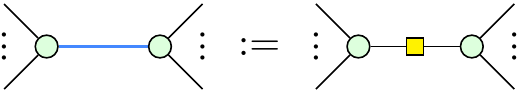

<hr style="border-bottom:3px solid black" />

## Question 1.3

Produce a circuit involving multiple CNOT gates in a variety of positions using QASM. Produce the same circuit as a composition of `zcopy`, `xmerge`, `swap`, and `wire` and draw both to compare.

<hr style="border-bottom:3px solid black" />

We can print out the matrix of a picture by writing `print_matrix`.

In [ ]:
lhs = zcopy * xmerge
zx.draw(lhs)
print_matrix(lhs)

In [ ]:
rhs = (xmerge @ xmerge) * (wire @ swap @ wire) * (zcopy @ zcopy)
zx.draw(rhs)
print_matrix(rhs)

If we want to check if two matrices are equal, it's best to use `zx.compare_tensors` (n.b. a "tensor" is another name for a matrix with multiple input/output indices, not to be confused with ⊗). This has a convenient extra argument called `preserve_scalar`, which when set to false, compares matrices up to a number.

In [ ]:
print(zx.compare_tensors(lhs, rhs, preserve_scalar=True))
print(zx.compare_tensors(lhs, rhs, preserve_scalar=False))

The matrix or tensor of a graph `g` can be obtained directly by calling `g.to_matrix()` or `g.to_tensor()`. These consist of floating point numbers, so comparing them with `==` is generally not a good idea, due to rounding errors.

Finally, note the `Graph` type has a `scalar` property, which holds an overall scalar factor, which is used when computing the matrix. It is equal to 1 (actually `zx.ONE`) by default.

In [ ]:
rhs1 = rhs.copy()
rhs1.scalar = zx.SQRT_TWO
print(zx.compare_tensors(lhs, rhs1, preserve_scalar=True))

Scalars are of type `Scalar`, which represents common scalars exactly (rather than as floating point). Some ready-made scalars are:
 * `zx.ONE`
 * `zx.TWO`
 * `zx.TWO_INV`, i.e. $\frac 1 2$
 * `zx.SQRT_TWO`
 * `zx.SQRT_TWO_INV`, i.e. $\frac{1}{\sqrt{2}}$

<hr style="border-bottom:3px solid black" />

## Question 1.4

Use `compare_tensors` to check your work on Question 1.3. Are the matrices of the two diagrams equal exactly, or up to a number? Why?

<hr style="border-bottom:3px solid black" />

<hr style="border-bottom:3px solid black" />

## Question 1.5

Create ZX-diagrams corresponding to the basis states for the Z basis (a.k.a. the "computational" or "standard" basis) and X basis (a.k.a. the "plus" basis). Use the `scalar` property to normalise them, and verify they produce the correct matrices.

<hr style="border-bottom:3px solid black" />

<hr style="border-bottom:3px solid black" />

## Question 1.6

Use `zx.qasm` to produce a 3-qubit circuit containing a variety of gates. By plugging the states from Question 1.5 into the inputs and their adjoints into their outputs, evaluate the complex amplitudes and the probabilities associated with several different inputs and measurement outcomes for this circuit. Choose a circuit and measurements so that at least some of these probabilities are different from 0 or 1.

<i>Hint: If a graph `g` has a 1x1 matrix, you can get the complex number out by calling `c = g.to_matrix()[0,0]`, and you can get its complex conjugate with `c.conjugate()`.</i>


<hr style="border-bottom:3px solid black" />

Now, let's apply some rules to ZX-diagrams. All of the rules we will use take a graph and one or more vertex id's as indices. We can see which vertices are where if we set `labels=True` on in `zx.draw`.

In [ ]:
g = zcopy * xmerge * (wire @ xmerge)
g.set_phase(3, 1)
zx.draw(g, labels=True)

Recall we included all of the rules in `pyzx.basicrules`. Notaby, these rules include:
 * `fuse(g, v1, v2)` - spider fusion
 * `color_change(g, v)` - color change a single spider
 * `strong_comp(g, v1, v2)` - strong complementarity
 * `remove_id(g, v)` - replace 1-to-1 spider with wire

Calling these functions will check whether a rule applies to the given vertices, apply it and return `True` (if it applies) or do nothing and return `False` (otherwise). There are also functions called `check_RULENAME(g, ...)` which will check if a rule applies without applying it.

In [ ]:
g1 = g.copy()
zx.draw(g1, labels=True)
fuse(g1, 4, 1)
zx.draw(g1, labels=True)
strong_comp(g1, 4, 5)
zx.draw(g1, labels=True)
zx.compare_tensors(g, g1, preserve_scalar=True)

Note that `strong_comp` is a bit more general than the normal strong complementarity rule, because it allows 0 or $\pi$ phases on either of the spiders, which get copied through.

Like with composition, rule applications are smart enough to remove parallel edges using the complementarity law.

In [ ]:
g = xmerge * (xmerge @ wire) * (wire @ zcopy)
g1 = g.copy()
zx.draw(g, labels=True)
fuse(g, 4, 6)
zx.draw(g, labels=True)
zx.compare_tensors(g, g1, preserve_scalar=True)

<hr style="border-bottom:3px solid black" />

## Question 1.7

Using the functions in `pyzx.basicrules`, show that 3 alternating CNOT gates is equal to a swap gate.

<i>Note: we can only apply the rules in one direction, so this proof will need to be different from the one given in Picturing Quantum Processes.</i>


<hr style="border-bottom:3px solid black" />

<hr style="border-bottom:3px solid black" />

## Question 1.8

Compose the circuit you made in Question 1.6 with its adjoint, and use ZX rules to prove the result is equal to the identity.


<hr style="border-bottom:3px solid black" />